# Time Series to Images (Ts2Img)

The Ts2Img module transfers observations from a time series data set into an image stack. The advantage of the image format is, that all observations around a similar time stamp can be loaded at once. The image format is therefore preferred over time series when loading data for large areas over a short time period.

## Source and target grid
The following plot shows how the input data is organised spatially. Blue dots are locations where a time series in the source data set is available. The black raster are the pixels of the target grid cells (where we want to transfer the time series to).

For this example, the source grid is the subset for Austria of the 12.5 km WARP Grid (used for ASCAT soil moisture data). The target is a gap-free 0.1 degree regular raster.

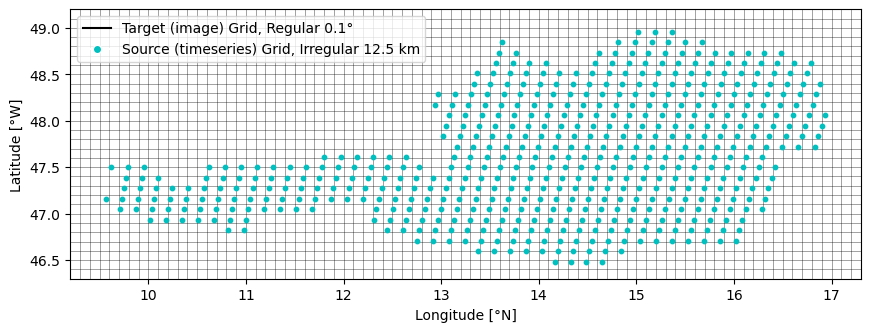

In [26]:
import os
from pygeogrids.grids import CellGrid
from pygeogrids.netcdf import load_grid
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np


source_grid = load_grid(os.path.join("assets", "warp_subgrid_AUT.nc"))
y = np.arange(46.3, 49.2, 0.1)
x = np.arange(9.2, 17.4, 0.1)
z = np.full((y.size-1, x.size-1), np.nan)

plt.figure(figsize=(10.2,3.5))
plt.pcolormesh(x, y, z, edgecolors='k', linewidth=0.5, alpha=0.2)
plt.scatter(source_grid.activearrlon, source_grid.activearrlat, s=10, c='c')

plt.xlabel('Longitude [°N]')
plt.ylabel('Latitude [°W]')

legend = [Line2D([0], [0], color='k', label='Target (image) Grid, Regular 0.1°'),
          Line2D([0], [0], marker='o', color='w', markerfacecolor='c', label='Source (timeseries) Grid, Irregular 12.5 km')]
plt.legend(handles=legend, loc='upper left')

## Input time series
For this example we create small reader class. Our time series are stored on the above shown "source grid". For most of the points there are soil moisture observations between 1st to 10th of June 2010 provided in a single csv file (see folder "assets"). The reader just finds the closest source point for a passed lon/lat pair and returns the according time series in that point

In [27]:
import pandas as pd

class Reader:
    def __init__(self):
        self.df = pd.read_csv(os.path.join("assets", "SM_AUT.csv"), index_col=[0, 1], parse_dates=True)
        self.grid: CellGrid = source_grid

    def read(self, lon, lat):
        # The only relevant part is, that the reader has a function that takes a latitude and longitude
        # and return a time series for the closest point.
        gpi, _ = self.grid.find_nearest_gpi(lon, lat)
        return self.df.loc[gpi]

We can try this and plot of few time of the time series that we find close to the passed coordinates.

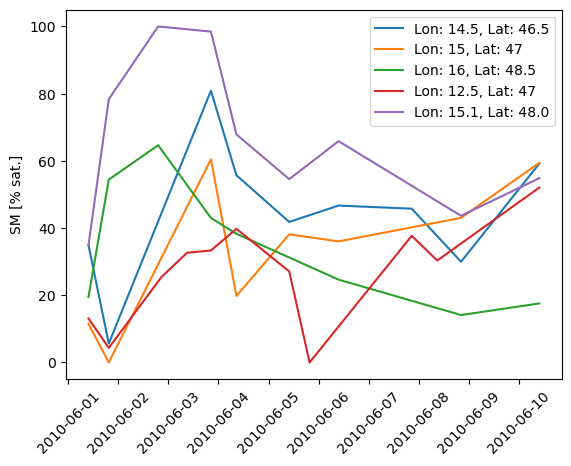

In [28]:
source_reader = Reader()
for lon, lat in [[14.5, 46.5], [15, 47], [16, 48.5], [12.5, 47], [15.1, 48.]]:
    ts = source_reader.read(lon, lat)
    plt.plot(ts, label=f"Lon: {lon}, Lat: {lat}")
plt.ylabel("SM [% sat.]")
plt.xticks(rotation = 45)
plt.legend()


## Output image stack

To create the image stack we need to decide:
1) The region of interest. The bounding box for which we create images and extract time series data for respectively. In our case we use the bounding box from the first Figure.
2) The pixel size we want to store the data on. Should be chosen according to the resolution of the time series grid. In our case we use a target grid of 0.1° as visualised in the first Figure.
3) The temporal sampling of our image stack. Should also be chosen according to the time series data. This is a bit tricky because, as you can see when looking at the data in "assets/SM_AUT.csv" we have varying time stamps for different locations. But overall we expect that we dont have more than 1 observations for each day and each point. So let's start with a daily temporal image sampling.

## Converter

The class to convert the time series data set into images is called `Ts2Img` and imported from `repurpose.ts2img`. We pass the above defined time series reader and create a regular image grid objects from the above defined dimensions. We allow up to 7 km for the nearest neighbour lookup between the target and source grid (remember that the source data is sampled at 12.5 km). We also pass time stamps that define the dates for which we create our images. Important: As we expect that there is a difference in the time stamps we use in the image stack and the time stamps we get from the time series, we have to perform temporal collocation to match them. If we would set `time_collocation=False`, it would be required that the same time stamps that we use in the image stack are also available in the time series data.


For some points the time series reading will fail. That's fine, we will just continue with the next point in those cases (we could adapt the source reader class to handle this more elegantly).

In [29]:
from repurpose.ts2img import Ts2Img
from pygeogrids.grids import gridfromdims

target_grid = gridfromdims(x, y)
timestamps = pd.date_range('2010-06-01T00:00:00', '2010-06-10T12:00:00', freq='12H')

converter = Ts2Img(ts_reader=source_reader, img_grid=target_grid, timestamps=timestamps, variables=['sm'], max_dist=10000, time_collocation=True)


The .calc function will then start the conversion. First we split the passed time stamps into chunks of the selected size. This is relevant for datasets that don't fit into memory. In our case a single chunk is fine. Then we loop over all points in the image stack and look for the according data in the time series data set. If a time series is found for a point, observations are written into the image stack, otherwise the fill value is kept. As this can be quite time-consuming for large data sets, there is a keyword to activate parallel processing (when `n_proc` is chosen greater than 1).

Other arguments:
- `format_out` to define whether you want to store one time stamp / single image in each netcdf file (`slice`) or the whole chunk (`stack`).
- `fn_template` to set the file name of the output files (make sure that the {datetime} placeholder is included.
- `drop_empty` to drop any empty images after conversion. This can be usefull if you expect that there are many time stamps without data and you want to save storage space (otherwise these files would contain only fill values).
- `encoding` to efficiently store data without wasting too much space, you can convert variable to a certain data type (e.g integers)  and provide scale factors (precision when converting floats as integers for efficient storage). Common encoding keywords are `scale_factor`, `add_offset`, `_FillValue`, `dtype` (see also https://docs.xarray.dev/en/stable/user-guide/io.html#scaling-and-type-conversions)
- `glob_attrs` and `var_attrs` metadata data is written to each file and each variable.
- `var_fillvalues` and `var_dtypes` can be used to force a certain value to use instead of NaN and convert to a different data type than the default float32. Note, it's better to use the encoding keyword for this!

In [30]:
from tempfile import mkdtemp
path_out = mkdtemp()
print(f"Images are stored in {path_out}")

converter.calc(path_out=path_out, format_out='slice', fn_template='ascat_0.1deg_{datetime}.nc',
               glob_attrs={'Description': 'ASCAT SSM resampled to regular 0.1 deg. grid'},
               var_attrs={'sm': {'unit': 'percent saturation', 'long_name': 'soil moisture'}},
               encoding={'sm': {'scale_factor': 0.01, 'dtype': 'int32', '_FillValue': -9999}},
               img_buffer=100, n_proc=1, drop_empty=True)

Images are stored in /tmp/tmpoba45j_a


Processed:   0%|          | 0/3 [00:00<?, ?it/s]ERROR:root:Error reading Time series data at lon: 9.499999999999998, lat: 47.500000000000014: 2399817
ERROR:root:Error reading Time series data at lon: 9.599999999999998, lat: 47.500000000000014: 2399817
ERROR:root:Error reading Time series data at lon: 9.699999999999998, lat: 47.500000000000014: 2399817
Processed:  33%|███▎      | 1/3 [00:02<00:04,  2.03s/it]ERROR:root:Error reading Time series data at lon: 13.499999999999984, lat: 47.80000000000002: 2412903
ERROR:root:Error reading Time series data at lon: 13.599999999999984, lat: 47.80000000000002: 2412903
Processed:  67%|██████▋   | 2/3 [00:18<00:10, 10.69s/it]ERROR:root:Error reading Time series data at lon: 16.599999999999973, lat: 47.70000000000002: 2408657
ERROR:root:Error reading Time series data at lon: 16.699999999999974, lat: 47.70000000000002: 2408657
ERROR:root:Error reading Time series data at lon: 16.799999999999972, lat: 47.70000000000002: 2408661
ERROR:root:Error reading

## Checking image
Looking at the so created images, you should see that there is the expected variable `sm` in the files, but also a variable `timedelta_seconds` that contains the difference in time between the original time stamps and the time stamps assigned to the image. Adding the offset to the image time stamp should result in the same time that was originally in the time series.

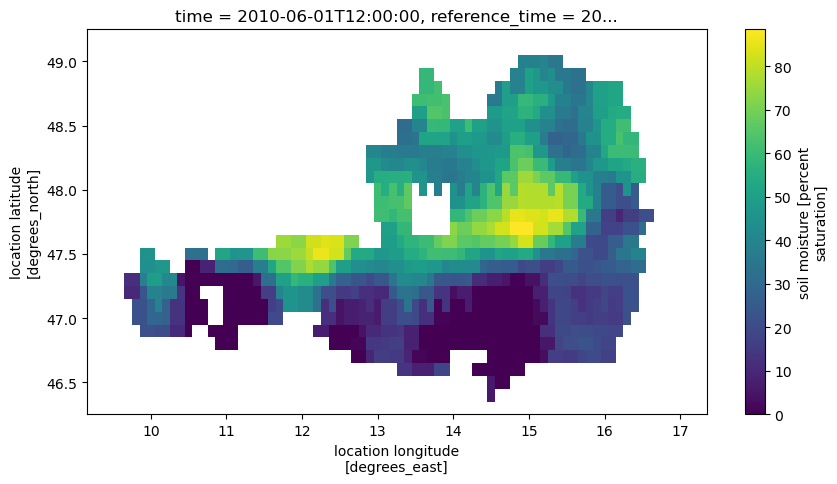

<Figure size 640x480 with 0 Axes>

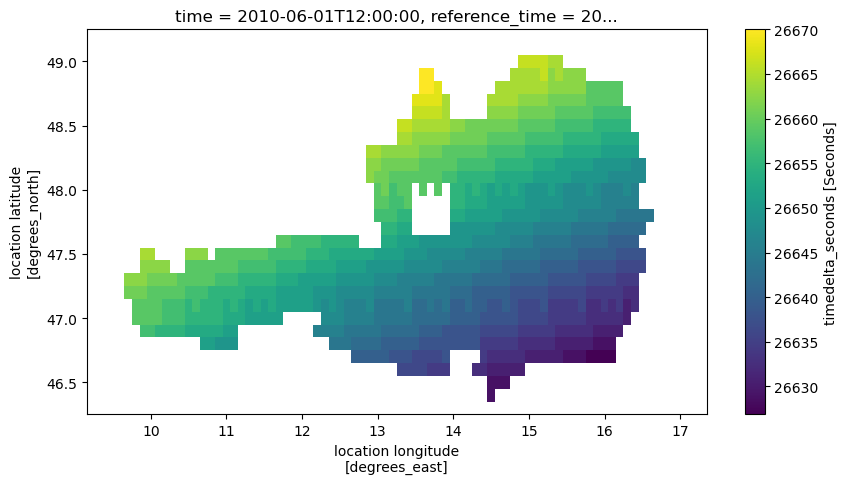

In [31]:
import xarray as xr

ds = xr.open_dataset(os.path.join(path_out, "2010", "ascat_0.1deg_20100601120000.nc"))

ds['sm'].plot(figsize=(10,5), cmap='RdBu')

plt.figure()
ds['timedelta_seconds'].plot(figsize=(10,5), cmap='rainbow')

Let's very that we have the same values as in the time series. First we read a time series for a certain day and location. We find the same soil moisture and time stamp value in both data sets.

In [32]:
ts = source_reader.read(14.5, 46.5).loc['2010-06-01T12':'2010-06-02']
print("Soil Moisture and time stamp in time series\n")
print(ts)

Soil Moisture and time stamp in time series

                              sm
time                            
2010-06-01 19:23:48.749991  5.64


In [33]:
from datetime import timedelta
img = ds.sel(lon=14.5, lat=46.5, method='nearest')

sm = img['sm'].values[0]
img_timestamp = pd.to_datetime(img['time'].values[0]).to_pydatetime()
timedetla = timedelta(seconds=float(img['timedelta_seconds'].values[0]))

print("Value and time stamp in image (after applying the timedetal_seconds to the image wide time stamp")
print("sm:", sm)
print("timestamp+offset:", img_timestamp + timedetla)

Value and time stamp in image (after applying the timedetal_seconds to the image wide time stamp
sm: 5.64
timestamp+offset: 2010-06-01 19:23:48.750000
